<a href="https://colab.research.google.com/github/Eshan133/bone_segmentation_naamii/blob/main/Bone_Segmentation_trial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install nibabel plotly kaleido

In [ ]:
import nibabel as nib
import numpy as np

In [ ]:
img = nib.load('/content/drive/MyDrive/3702_left_knee.nii.gz')

In [ ]:
data = img.get_fdata()

In [ ]:
print("Data shape:", data.shape)  # Should be (512, 512, 216)
print("Data type:", data.dtype)
print("Data min/max:", data.min(), data.max())
print("Data mean/std:", data.mean(), data.std())
print("Data percentiles (10th, 50th, 90th):", np.percentile(data, [10, 50, 90]))

Data shape: (512, 512, 216)
Data type: float64
Data min/max: -3024.0 1769.0
Data mean/std: -1112.6603342868664 725.6593123483354
Data percentiles (10th, 50th, 90th): [-3024. -1000.  -880.]


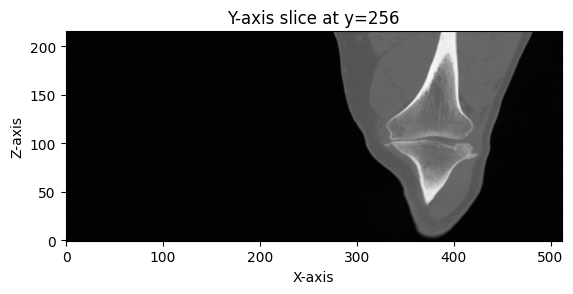

<Figure size 640x480 with 0 Axes>

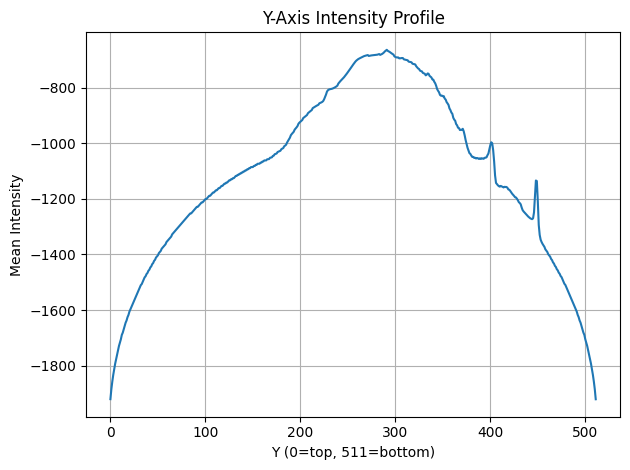

In [ ]:
# Y-axis slice (coronal, x-z plane)
y_idx = data.shape[1] // 2  # y=256
slice_y = data[:, y_idx, :]

# Display the slice
plt.imshow(slice_y.T, cmap='gray', origin='lower')
plt.title(f"Y-axis slice at y={y_idx}")
plt.xlabel("X-axis")
plt.ylabel("Z-axis")
plt.show()


plt.tight_layout()
plt.show()


# Check content along each axis (mean intensity profiles)
y_profile = np.mean(data, axis=(0, 2))  # Mean over x, z for each y


plt.plot(y_profile)
plt.title("Y-Axis Intensity Profile")
plt.xlabel("Y (0=top, 511=bottom)")
plt.ylabel("Mean Intensity")
plt.grid(True)


plt.tight_layout()
plt.show()

In [ ]:
# import os
# import numpy as np
# import nibabel as nib
# import matplotlib.pyplot as plt
# from PIL import Image
# import zipfile

# # Output folder for slices
# output_folder = "/content/y_slices"
# os.makedirs(output_folder, exist_ok=True)

# # Save each slice
# for y in range(data.shape[1]):  # y-axis: 0 to 511
#     slice_2d = data[:, y, :]     # shape (512, 216)

#     # Normalize slice for saving as image (0-255)
#     slice_norm = 255 * (slice_2d - np.min(slice_2d)) / (np.ptp(slice_2d) + 1e-5)
#     slice_img = Image.fromarray(np.flipud(slice_norm.T).astype(np.uint8))  # Transpose + vertical flip

#     # Save the image
#     slice_img.save(f"{output_folder}/slice_y_{y:03d}.png")

# print("✅ All slices saved!")

# # Zip the folder
# zip_path = "/content/y_slices.zip"
# with zipfile.ZipFile(zip_path, 'w') as zipf:
#     for root, _, files in os.walk(output_folder):
#         for file in files:
#             zipf.write(os.path.join(root, file),
#                        arcname=os.path.relpath(os.path.join(root, file), output_folder))

# print("✅ Zip file created!")

# # Download the zip file
# from google.colab import files
# files.download(zip_path)

✅ All slices saved!
✅ Zip file created!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

----
## Task 1.1
- CT scans are 3D volumetric images where each voxel has an intensity value in Hounsfield Units (HU).
- Bones typically have high HU values (e.g., 200–1000 HU), while soft tissues are lower (e.g., -100 to 100 HU).

Techniques for Segmentation:
-Thresholding: Select voxels within a specific HU range for bones.
Connected
- Component Analysis: Identify distinct bone regions (e.g., femur vs. tibia).
- Morphological Operations: Clean up noise or fill small gaps in the mask.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import nibabel as nib
import numpy as np

In [3]:
img = nib.load('/content/drive/MyDrive/3702_left_knee.nii.gz')

In [4]:
data = img.get_fdata()

In [5]:
print("Data shape:", data.shape)  # Should be (512, 512, 216)
print("Data type:", data.dtype)
print("Data min/max:", data.min(), data.max())
print("Data mean/std:", data.mean(), data.std())
print("Data percentiles (10th, 50th, 90th):", np.percentile(data, [10, 50, 90]))

Data shape: (512, 512, 216)
Data type: float64
Data min/max: -3024.0 1769.0
Data mean/std: -1112.6603342868664 725.6593123483354
Data percentiles (10th, 50th, 90th): [-3024. -1000.  -880.]


In [ ]:
import nibabel as nib
import numpy as np
from scipy.ndimage import label, binary_closing
import os

def load_ct_scan(file_path):
    """Load a CT scan and return the image array and NIfTI object."""
    img = nib.load(file_path)
    data = img.get_fdata()
    return data, img

def threshold_slice(data, lower_hu=200, upper_hu=1000):
    """Apply thresholding to isolate bone voxels."""
    return (data >= lower_hu) & (data <= upper_hu)

def segment_along_y_axis(data):
    """Segment bones slice-by-slice along the y-axis."""
    ny = data.shape[1]  # Number of slices along y-axis
    bone_mask = np.zeros_like(data, dtype=np.uint8)  # 3D mask

    # Process each y-slice
    for y in range(ny):
        slice_data = data[:, y, :]  # 2D slice (x, z)
        slice_mask = threshold_slice(slice_data)
        bone_mask[:, y, :] = slice_mask.astype(np.uint8)

    # Apply 3D connected component analysis to ensure continuity
    labeled_array, num_features = label(bone_mask)

    # Identify two largest components (assumed to be femur and tibia)
    sizes = np.bincount(labeled_array.ravel())[1:]  # Ignore background
    if len(sizes) < 2:
        raise ValueError("Fewer than two bone components detected.")
    largest_components = np.argsort(sizes)[-2:] + 1  # Indices of two largest

    # Create initial masks
    mask1 = (labeled_array == largest_components[0]).astype(np.uint8)
    mask2 = (labeled_array == largest_components[1]).astype(np.uint8)

    # Separate femur and tibia based on z-coordinate (inferior-superior)
    # Femur is higher (smaller z), tibia is lower (larger z)
    centroid1 = np.mean(np.where(mask1), axis=1)  # [x, y, z]
    centroid2 = np.mean(np.where(mask2), axis=1)

    # Alternative: Use y-coordinate if needed (anterior-posterior)
    # Comment out z-based and uncomment y-based if y-axis is preferred
    if centroid1[2] < centroid2[2]:
        femur_mask, tibia_mask = mask1, mask2
    else:
        femur_mask, tibia_mask = mask2, mask1

    # Optional: Use y-coordinate for separation
    # if centroid1[1] < centroid2[1]:
    #     femur_mask, tibia_mask = mask1, mask2
    # else:
    #    –

    return femur_mask, tibia_mask

def refine_mask(mask):
    """Apply morphological operations to clean the mask."""
    # Apply binary closing to fill small holes
    return binary_closing(mask, structure=np.ones((3, 3, 3))).astype(np.uint8)

def save_mask(mask, template_img, output_path):
    """Save the mask as a .nii.gz file."""
    mask_img = nib.Nifti1Image(mask, template_img.affine, template_img.header)
    nib.save(mask_img, output_path)


In [ ]:
# Define paths
input_path = "/content/drive/MyDrive/3702_left_knee.nii.gz"  # Update with actual path
output_dir = "results"
os.makedirs(output_dir, exist_ok=True)
femur_output = os.path.join(output_dir, "femur_mask.nii.gz")
tibia_output = os.path.join(output_dir, "tibia_mask.nii.gz")

# Step 1: Load CT scan
print("Loading CT scan...")
data, img = load_ct_scan(input_path)

# Step 2: Segment along y-axis
print("Segmenting bones along y-axis...")
femur_mask, tibia_mask = segment_along_y_axis(data)

# Step 3: Refine masks
print("Refining masks...")
femur_mask = refine_mask(femur_mask)
tibia_mask = refine_mask(tibia_mask)

# Step 4: Save masks
print("Saving masks...")
save_mask(femur_mask, img, femur_output)
save_mask(tibia_mask, img, tibia_output)
print(f"Saved masks to {femur_output} and {tibia_output}")

Loading CT scan...
Segmenting bones along y-axis...
Refining masks...
Saving masks...
Saved masks to results/femur_mask.nii.gz and results/tibia_mask.nii.gz


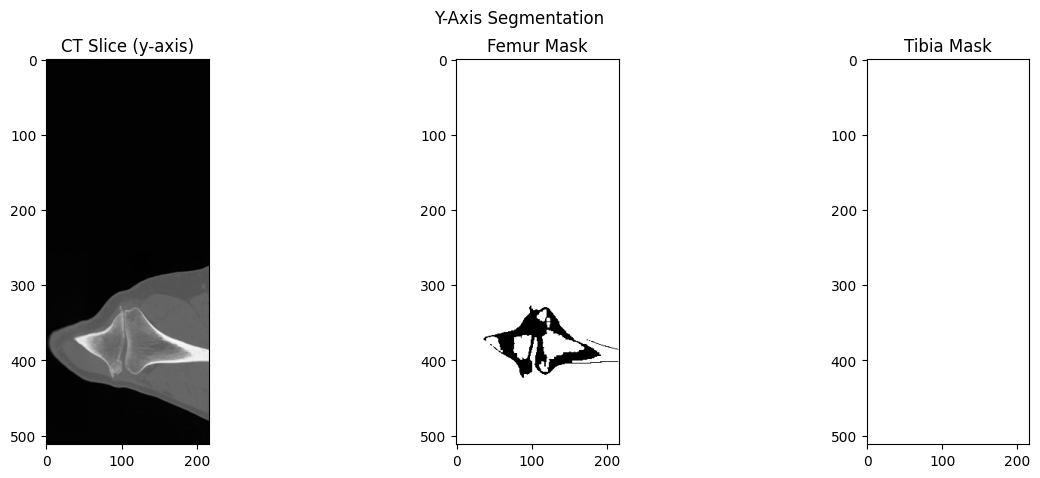

In [ ]:
import matplotlib.pyplot as plt

def visualize_y_slice(data, femur_mask, tibia_mask, y_idx, title):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(data[:, y_idx, :], cmap="gray")
    plt.title("CT Slice (y-axis)")
    plt.subplot(1, 3, 2)
    plt.imshow(femur_mask[:, y_idx, :], cmap="binary")
    plt.title("Femur Mask")
    plt.subplot(1, 3, 3)
    plt.imshow(tibia_mask[:, y_idx, :], cmap="binary")
    plt.title("Tibia Mask")
    plt.suptitle(title)
    plt.show()

# Add to main() after segmentation
visualize_y_slice(data, femur_mask, tibia_mask, data.shape[1] // 2, "Y-Axis Segmentation")

### Slice-by-Slice Segmentation (My Idea)
This method works but has limitations:

Pros:
- Simpler to implement.
- Can be used with 2D CNNs if you’re doing deep learning.

Cons:
- May result in inconsistent masks across slices.
- Ignores 3D structure continuity.
- Hard to differentiate tibia/femur when overlap exists in 2D.

| Approach                 | Use Case                    | Tools             | Accuracy |
| ------------------------ | --------------------------- | ----------------- | -------- |
| **nnU-Net (3D)**         | Best overall, generalizable | nnU-Net           | ⭐⭐⭐⭐⭐    |
| **MONAI + 3D U-Net**     | Custom pipelines            | PyTorch + MONAI   | ⭐⭐⭐⭐     |
| **Classical Processing** | Simpler, non-ML             | SimpleITK, OpenCV | ⭐⭐⭐      |
| **Slice-by-Slice**       | Simpler, but less robust    | 2D U-Net          | ⭐⭐       |


In [6]:
import nibabel as nib
import numpy as np
import cv2
from skimage import measure
from tqdm import tqdm
import os

In [8]:
segmentation_mask = np.zeros_like(data, dtype=np.uint8)

In [9]:
# Process slices along y-axis (0 to 511)
for y in tqdm(range(data.shape[1])):  # y-axis
    slice_img = data[:, y, :]  # shape: (512, 256)

    # Normalize to 0–255
    slice_norm = 255 * (slice_img - np.min(slice_img)) / (np.ptp(slice_img) + 1e-5)
    slice_uint8 = slice_norm.astype(np.uint8)

    # Preprocessing: blur
    blurred = cv2.GaussianBlur(slice_uint8, (5, 5), 0)

    # Thresholding
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Morph operations
    kernel = np.ones((5, 5), np.uint8)
    morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)
    morph = cv2.morphologyEx(morph, cv2.MORPH_OPEN, kernel, iterations=1)

    # Regionprops filtering
    labels = measure.label(morph)
    props = measure.regionprops(labels)
    slice_mask = np.zeros_like(slice_img, dtype=np.uint8)

    for prop in props:
        if prop.area > 1000:  # adjust based on your anatomy
            slice_mask[labels == prop.label] = 1

    # Insert the mask back into the 3D array
    segmentation_mask[:, y, :] = slice_mask


100%|██████████| 512/512 [00:03<00:00, 169.51it/s]


In [10]:
# Save as NIfTI
seg_img = nib.Nifti1Image(segmentation_mask.astype(np.uint8), img.affine)
nib.save(seg_img, '/content/segmented_knee_yaxis_mask.nii.gz')
print("✅ Saved y-axis-based segmentation as 'segmented_knee_yaxis_mask.nii.gz'")


✅ Saved y-axis-based segmentation as 'segmented_knee_yaxis_mask.nii.gz'


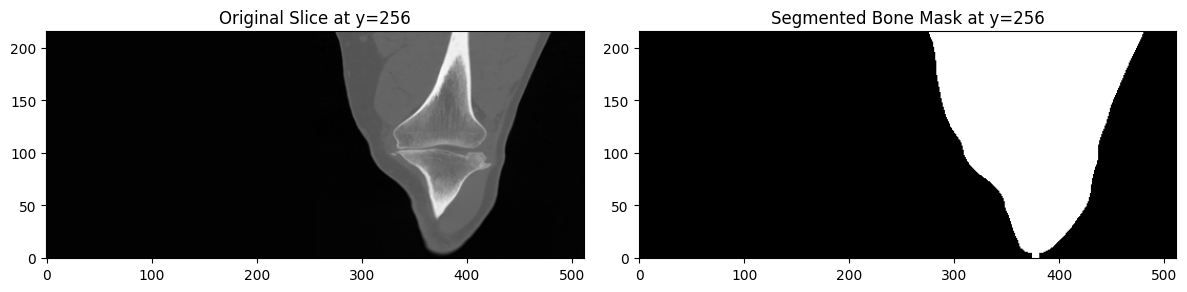

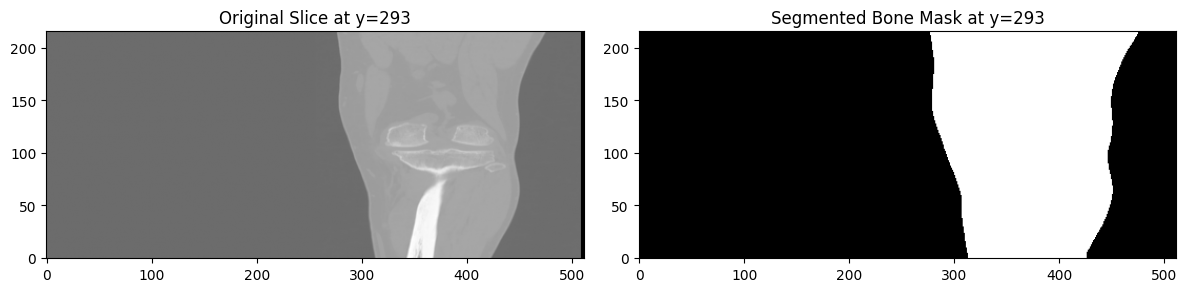

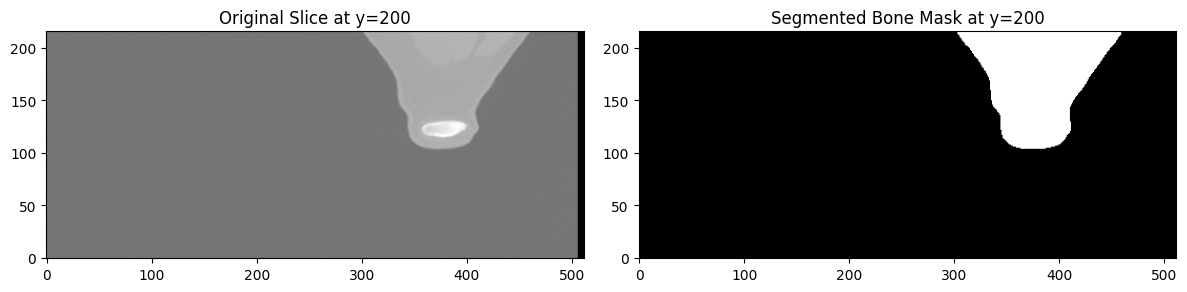

In [13]:
import matplotlib.pyplot as plt

def visualize_y_slice(y_index):
    """Visualizes original and segmented data at a given y-slice index"""
    original = data[:, y_index, :]          # shape: (512, 256)
    segmented = segmentation_mask[:, y_index, :]

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.title(f'Original Slice at y={y_index}')
    plt.imshow(original.T, cmap='gray', origin='lower')  # transpose to (256, 512)

    plt.subplot(1, 2, 2)
    plt.title(f'Segmented Bone Mask at y={y_index}')
    plt.imshow(segmented.T, cmap='gray', origin='lower')

    plt.tight_layout()
    plt.show()

# Try visualizing a few different slices
visualize_y_slice(256)
visualize_y_slice(293)
visualize_y_slice(200)


In [31]:
import numpy as np
import nibabel as nib
from skimage import measure, morphology
from scipy.ndimage import label
import matplotlib.pyplot as plt
from tqdm import tqdm

In [33]:
# Prepare output masks
femur_mask = np.zeros_like(data, dtype=np.uint8)
tibia_mask = np.zeros_like(data, dtype=np.uint8)

# Loop over Y-axis (axis=1)
for y in tqdm(range(data.shape[1])):
    slice_img = data[:, y, :]  # axial slice

    # Step 1: Threshold for bone
    slice_bone = (slice_img >= 200) & (slice_img <= 1000)

    # Step 2: Connected components
    labeled, num_labels = label(slice_bone)

    if num_labels < 2:
        continue  # skip if not enough components

    # Step 3: Get two largest regions
    props = measure.regionprops(labeled)
    props = sorted(props, key=lambda x: x.area, reverse=True)

    femur_lbl = props[0].label
    tibia_lbl = props[1].label

    femur_mask[:, y, :][labeled == femur_lbl] = 1
    tibia_mask[:, y, :][labeled == tibia_lbl] = 1

# Step 4: Morphological cleanup (entire 3D volume)
from skimage.morphology import ball, binary_closing

femur_mask = binary_closing(femur_mask).astype(np.uint8)
tibia_mask = binary_closing(tibia_mask).astype(np.uint8)

# Save the masks
nib.save(nib.Nifti1Image(femur_mask, img.affine), '/content/femur_mask_yaxis.nii.gz')
nib.save(nib.Nifti1Image(tibia_mask, img.affine), '/content/tibia_mask_yaxis.nii.gz')

print("✅ Femur and tibia masks created by slicing along y-axis and saved.")

100%|██████████| 512/512 [00:01<00:00, 342.71it/s]


✅ Femur and tibia masks created by slicing along y-axis and saved.


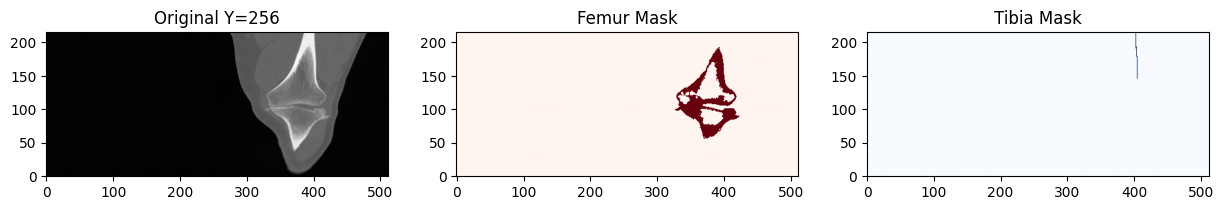

In [35]:
def show_y_slice(y=128):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title(f'Original Y={y}')
    plt.imshow(data[:, y, :].T, cmap='gray', origin='lower')

    plt.subplot(1, 3, 2)
    plt.title('Femur Mask')
    plt.imshow(femur_mask[:, y, :].T, cmap='Reds', origin='lower')

    plt.subplot(1, 3, 3)
    plt.title('Tibia Mask')
    plt.imshow(tibia_mask[:, y, :].T, cmap='Blues', origin='lower')
    plt.show()

show_y_slice(256)  # adjust y as needed


In [36]:
import nibabel as nib
import numpy as np
from scipy.ndimage import label, binary_closing
import matplotlib.pyplot as plt
import os

def load_ct_scan(file_path):
    """Load a .nii.gz CT scan and return the voxel array and NIfTI object."""
    try:
        img = nib.load(file_path)
        data = img.get_fdata()  # 3D numpy array
        return data, img
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None, None

def threshold_y_axis(data, lower_hu=200, upper_hu=1000):
    """Threshold the CT scan slice-by-slice along the y-axis to isolate bones."""
    bone_mask = np.zeros_like(data, dtype=np.uint8)
    for y in range(data.shape[1]):
        slice_data = data[:, y, :]  # x, z slice
        slice_mask = (slice_data >= lower_hu) & (slice_data <= upper_hu)
        bone_mask[:, y, :] = slice_mask.astype(np.uint8)
    return bone_mask

def separate_femur_tibia(bone_mask):
    """Separate femur and tibia using connected component analysis and z-coordinates."""
    # 3D connected component analysis
    labeled_array, num_features = label(bone_mask)
    if num_features < 2:
        raise ValueError(f"Expected at least 2 components, found {num_features}")

    # Identify two largest components
    sizes = np.bincount(labeled_array.ravel())[1:]  # Exclude background
    largest_components = np.argsort(sizes)[-2:] + 1  # Indices of two largest

    # Create masks for the two components
    mask1 = (labeled_array == largest_components[0]).astype(np.uint8)
    mask2 = (labeled_array == largest_components[1]).astype(np.uint8)

    # Assign femur (higher z) and tibia (lower z) based on centroid z-coordinate
    centroid1 = np.mean(np.where(mask1), axis=1)  # [x, y, z]
    centroid2 = np.mean(np.where(mask2), axis=1)
    femur_mask = mask1 if centroid1[2] < centroid2[2] else mask2
    tibia_mask = mask2 if centroid1[2] < centroid2[2] else mask1

    return femur_mask, tibia_mask

def refine_mask(mask):
    """Apply morphological operations to clean the mask."""
    return binary_closing(mask, structure=np.ones((3, 3, 3))).astype(np.uint8)

def save_mask(mask, template_img, output_path):
    """Save the mask as a .nii.gz file."""
    mask_img = nib.Nifti1Image(mask, template_img.affine, template_img.header)
    nib.save(mask_img, output_path)

def visualize_y_slice(data, femur_mask, tibia_mask, y_idx, title="Y-Axis Segmentation"):
    """Visualize a y-axis slice of the CT scan and masks."""
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(data[:, y_idx, :], cmap="gray")
    plt.title(f"CT Slice (y={y_idx})")
    plt.axis("off")
    plt.subplot(1, 3, 2)
    plt.imshow(femur_mask[:, y_idx, :], cmap="binary")
    plt.title("Femur Mask")
    plt.axis("off")
    plt.subplot(1, 3, 3)
    plt.imshow(tibia_mask[:, y_idx, :], cmap="binary")
    plt.title("Tibia Mask")
    plt.axis("off")
    plt.suptitle(title)
    plt.show()


Shape (x, y, z): (512, 512, 216)
Voxel size (mm): (np.float32(0.869141), np.float32(0.869141), np.float32(2.0))
Intensity range (HU): -3024.0 to 1769.0
Thresholding along y-axis...
Separating femur and tibia...
Refining masks...


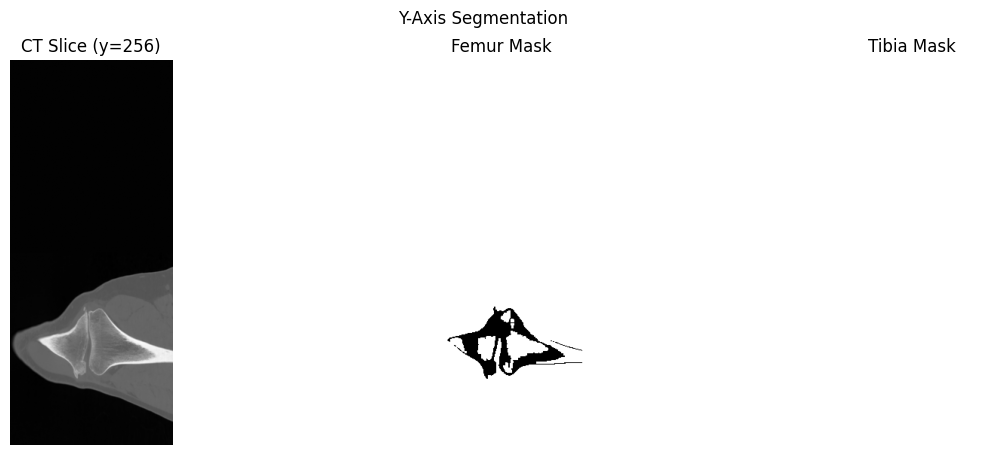

Saving masks...


NameError: name 'femur_output' is not defined

In [40]:



# Print basic properties
print("Shape (x, y, z):", data.shape)
print("Voxel size (mm):", img.header.get_zooms())
print("Intensity range (HU):", data.min(), "to", data.max())

# Segment bones along y-axis
print("Thresholding along y-axis...")
bone_mask = threshold_y_axis(data)

# Separate femur and tibia
print("Separating femur and tibia...")
femur_mask, tibia_mask = separate_femur_tibia(bone_mask)

# Refine masks
print("Refining masks...")
femur_mask = refine_mask(femur_mask)
tibia_mask = refine_mask(tibia_mask)

# Visualize a y-axis slice
y_mid = data.shape[1] // 2
visualize_y_slice(data, femur_mask, tibia_mask, y_mid)

# Save masks
print("Saving masks...")
save_mask(femur_mask, img, femur_output)
save_mask(tibia_mask, img, tibia_output)
print(f"Saved masks to {femur_output} and {tibia_output}")